In [34]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
def readLangs(input_file, target_file, input_lang, target_lang, size):
    print("Reading lines...")

    # Read the file and split into lines
    with open(input_file, encoding='utf-8') as file:
        input_lines = [next(file).strip() for x in range(size)]
        
    with open(target_file, encoding='utf-8') as file:
        target_lines = [next(file).strip() for x in range(size)]

    lines = list(zip(input_lines, target_lines))
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l] for l in lines]
    print(pairs[0])

    input_lang = Lang(input_lang)
    target_lang = Lang(target_lang)

    return input_lang, target_lang, pairs

In [6]:
def readLangs(input_file, target_file, input_lang, target_lang):
    print("Reading lines...")

    # Read the file and split into lines
    input_lines = open(input_file, encoding='utf-8').read().strip().split("\n")
        
    target_lines = open(target_file, encoding='utf-8').read().strip().split("\n")
    if input_lang == "zh":
        target_pairs = [normalizeString(s) for s in target_lines]
        pairs = list(zip(input_lines, target_pairs))
    else:
        lines = list(zip(input_lines, target_lines))
        # Split every line into pairs and normalize
        pairs = [[normalizeString(s) for s in l] for l in lines]
    print(pairs[0])

    input_lang = Lang(input_lang)
    target_lang = Lang(target_lang)

    return input_lang, target_lang, pairs

In [97]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

def prepareData(input_file, target_file, input_lang, target_lang, size):
    
    input_lang, target_lang, pairs = readLangs(input_file, target_file, input_lang, target_lang, size)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    print(pairs[0])
    for pair in pairs:
        input_lang.addSentence(pair[0])
        target_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(target_lang.name, target_lang.n_words)
    return input_lang, target_lang, pairs

input_file = 'iwslt-vi-en-processed/train.vi'
target_file = 'iwslt-vi-en-processed/train.en'
input_lang, target_lang, pairs = prepareData(input_file, target_file, 'vi', 'eng', size=50000)

Reading lines...
['khoa hoc ang sau mot tieu e ve khi hau', 'rachel pike the science behind a climate headline']
Read 50000 sentence pairs
Trimmed to 37026 sentence pairs
Counting words...
['khoa hoc ang sau mot tieu e ve khi hau', 'rachel pike the science behind a climate headline']
Counted words:
vi 5551
eng 19344


In [18]:
print(pairs[4][0])
print(pairs[4][1])

va tat ca cac trang eu uoc xem xet boi khoa hoc gia va nha phe binh khac tu quoc gia .
and all of those pages were reviewed by another plus scientists and reviewers from countries .


In [52]:
import pickle
pickle.dump(pairs, open("preprocessed_data_no_elmo/iwslt-vi-eng/preprocessed_no_indices_pairs_test", "wb"))
pickle.dump(input_lang, open("preprocessed_data_no_elmo/iwslt-zh-eng/preprocessed_no_elmo_zhlang", "wb"))
pickle.dump(target_lang, open("preprocessed_data_no_elmo/iwslt-zh-eng/preprocessed_no_elmo_englang", "wb"))


### The Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        # output and hidden are the same vectors
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training
#### Preparing Training Data

In [12]:
def indexesFromSentence(lang, sentence):
    words = sentence.split(' ')
    indices = []
    for word in words:
        if lang.word2index.get(word) is not None:
            indices.append(lang.word2index[word])
        else:
            indices.append(1) # UNK_INDEX
    return indices


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, target_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(target_lang, pair[1])
    return (input_tensor, target_tensor)



### Training the Model

In [10]:
teacher_forcing_ratio = 0.5


# example of input_tensor: [2, 43, 23, 9, 19, 4]. Indexed on our vocabulary. 
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # iterate GRU over words --> final hidden state is representation of source sentence. 
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

In [96]:
def load_cpickle_gc(dirlink):
    # https://stackoverflow.com/questions/26860051/how-to-reduce-the-time-taken-to-load-a-pickle-file-in-python
    output = open(dirlink, 'rb')

    # disable garbage collector
    gc.disable()

    mydict = pickle.load(output)

    # enable garbage collector again
    gc.enable()
    output.close()
    return mydict

def trainIters(encoder, decoder, n_iters,n_epochs,  lang1, lang2,  print_every=1000, plot_every=100, learning_rate=0.001):
    """
    lang1 is the Lang object for language 1 
    Lang2 is the Lang object for language 2
    """
    pairs = load_cpickle_gc("preprocessed_data_no_elmo/iwslt-"+lang1.name+"-"+lang2.name+"/preprocessed_no_indices_pairs_train")
    validation_pairs = load_cpickle_gc("preprocessed_data_no_elmo/iwslt-"+lang1.name+"-"+lang2.name+"/preprocessed_no_indices_pairs_train")
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    for i in range(n_epochs):
        training_pairs = [tensorsFromPair(random.choice(pairs))
                          for i in range(n_iters)]
        criterion = nn.NLLLoss()
        # framing it as a categorical loss function. 
        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1] 
            d_input_tensor = training_pair[0]
            d_target_tensor = training_pair[1]
            input_tensor = tensorFromSentence(lang1, d_input_tensor)
            target_tensor = tensorFromSentence(lang2, d_target_tensor)
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion, MAX_LENGTH_VI_EN)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('TRAIN SCORE %s (%d %d%%) %.4f' % (timeSince(start, iter / n_epochs),
                                             iter, iter / n_epochs * 100, print_loss_avg))
                val_loss = test_model(encoder, decoder,search, validation_pairs, lang1, max_length=MAX_LENGTH)
                # retursn teh bleu score
                print("VALIDATION BLEU SCORE: "+str(val_loss))

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)

In [13]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 4s (- 30m 30s) (100 0%) 5.5968
0m 7s (- 23m 48s) (200 0%) 5.7728
0m 9s (- 21m 19s) (300 0%) 5.4151
0m 12s (- 19m 50s) (400 1%) 4.8211
0m 14s (- 18m 59s) (500 1%) 4.8875
0m 16s (- 18m 23s) (600 1%) 5.0768
0m 19s (- 17m 55s) (700 1%) 4.8321
0m 21s (- 17m 53s) (800 2%) 5.2649
0m 24s (- 17m 40s) (900 2%) 5.0137
0m 26s (- 17m 28s) (1000 2%) 5.0703
0m 29s (- 17m 22s) (1100 2%) 5.2074
0m 31s (- 17m 11s) (1200 3%) 5.1661
0m 34s (- 17m 4s) (1300 3%) 5.1774
0m 36s (- 16m 55s) (1400 3%) 5.0282
0m 39s (- 16m 50s) (1500 3%) 4.9627
0m 41s (- 16m 44s) (1600 4%) 5.0080
0m 44s (- 16m 40s) (1700 4%) 4.9593
0m 46s (- 16m 30s) (1800 4%) 4.6759
0m 49s (- 16m 24s) (1900 4%) 4.8190
0m 51s (- 16m 19s) (2000 5%) 4.8904
0m 54s (- 16m 16s) (2100 5%) 4.7480
0m 56s (- 16m 12s) (2200 5%) 4.7285
0m 59s (- 16m 8s) (2300 5%) 4.7287
1m 1s (- 16m 4s) (2400 6%) 5.0598
1m 4s (- 16m 0s) (2500 6%) 4.7493
1m 6s (- 15m 59s) (2600 6%) 4.9447
1m 9s (- 15m 57s) (2700 6%) 5.0564
1m 11s (- 15m 54s) (2800 7%) 4.9927
1m 14s (- 15

9m 33s (- 7m 30s) (22400 56%) 4.6210
9m 35s (- 7m 27s) (22500 56%) 4.3865
9m 38s (- 7m 25s) (22600 56%) 4.5847
9m 41s (- 7m 22s) (22700 56%) 4.7381
9m 43s (- 7m 20s) (22800 56%) 4.4532
9m 46s (- 7m 17s) (22900 57%) 4.5935
9m 49s (- 7m 15s) (23000 57%) 4.6728
9m 51s (- 7m 12s) (23100 57%) 4.5673
9m 54s (- 7m 10s) (23200 57%) 4.3248
9m 57s (- 7m 7s) (23300 58%) 4.3180
9m 59s (- 7m 5s) (23400 58%) 4.6260
10m 2s (- 7m 3s) (23500 58%) 4.6635
10m 5s (- 7m 0s) (23600 59%) 4.4617
10m 7s (- 6m 57s) (23700 59%) 4.5282
10m 10s (- 6m 55s) (23800 59%) 4.6344
10m 12s (- 6m 52s) (23900 59%) 4.3259
10m 15s (- 6m 50s) (24000 60%) 4.3940
10m 17s (- 6m 47s) (24100 60%) 4.3862
10m 20s (- 6m 45s) (24200 60%) 4.3457
10m 23s (- 6m 42s) (24300 60%) 4.5836
10m 26s (- 6m 40s) (24400 61%) 4.6074
10m 28s (- 6m 37s) (24500 61%) 4.6000
10m 31s (- 6m 35s) (24600 61%) 4.7515
10m 34s (- 6m 32s) (24700 61%) 4.3044
10m 36s (- 6m 30s) (24800 62%) 4.5589
10m 39s (- 6m 27s) (24900 62%) 4.6115
10m 42s (- 6m 25s) (25000 62%)

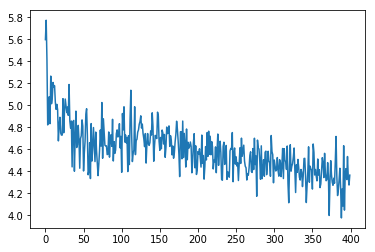

In [44]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(target_lang.n_words, hidden_size).to(device)

num_iters = 40000
trainIters(encoder1, decoder1, num_iters, print_every=100)

In [46]:
# torch.save(encoder1.state_dict(), "encoder1_40000")
# torch.save(decoder1.state_dict(), "decoder1_40000")

In [135]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder1.load_state_dict(torch.load("encoder1_40000", map_location='cpu'))
decoder1 = DecoderRNN(target_lang.n_words, hidden_size).to(device)
decoder1.load_state_dict(torch.load("decoder1_40000", map_location='cpu'))

evaluateRandomly(encoder1, decoder1, n = 10, strategy='beam', k = 8)

> va mot le khac la viec quyet inh tu nao tot va tu nao xau that su cha de dang gi .
= and for another deciding what words are good and what words are bad is actually not very easy .
< SOS and s another thing and that s going to be . EOS

> toi bi lai thay say sua voi tam quan trong cua cong viec minh lam .
= and i was hooked again on the importance of what i did .
< SOS i was doing doing that . EOS

> gv toi muon thay oi cuoc oi !
= t i want to change my life !
< SOS i want to change ! EOS

> vao nam o phai la phut e co uoc luong anh sang o tu muc luong trung binh .
= and back in it would have been minutes to earn that amount of light on the average wage .
< SOS and then it s in the to to EOS

> co cam xuc cua nan nhan .
= there are emotions of the victims .
< SOS there is that . EOS

> nhung ngay xua lam uoc chuyen nay rat kho khi phai chon cac con con co voc dang ac trung roi gay giong chung .
= but we had to do it the hard way in the old days by choosing offspring that looked a par

In [129]:
def evaluateRandomly(encoder, decoder, n=10, strategy="greedy", k = None):
    """
    Randomly select a sentence from the input dataset and try to produce its translation.
    """    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = generate_translation(encoder, decoder, pair[0], search=strategy, k = k)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [71]:
def generate_translation(encoder, decoder, sentence, max_length=MAX_LENGTH, search="greedy", k = None):
    """ 
    @param max_length: the max # of words that the decoder can return
    @returns decoded_words: a list of words in target language
    """    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # encode the source sentence
        encoder_hidden = encoder.initHidden()
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        # start decoding
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []
        
        if search == 'greedy':
            decoded_words = greedy_search(decoder, decoder_input, decoder_hidden, max_length)
        elif search == 'beam':
            if k == None:
                k = 2
            decoded_words = beam_search(decoder, decoder_input, decoder_hidden, max_length, k)  

        return decoded_words

In [127]:
def greedy_search(decoder, decoder_input, hidden, max_length):
    translation = []
    for i in range(max_length):
        next_word_softmax, hidden = decoder(decoder_input, hidden)
        best_idx = torch.max(next_word_softmax, 1)[1].squeeze().item()

        # convert idx to word
        best_word = target_lang.index2word[best_idx]
        translation.append(best_word)
        decoder_input = torch.tensor([[best_idx]], device=device)
        
        if best_word == 'EOS':
            break
    return translation


def beam_search(decoder, decoder_input, hidden, max_length, k):
    
    candidates = [(decoder_input, 0, hidden)]
    potential_candidates = []
    completed_translations = []

    # put a cap on the length of generated sentences
    for m in range(max_length):
        for c in candidates:
            # unpack the tuple
            c_sequence = c[0]
            c_score = c[1]
            c_hidden = c[2]
            # EOS token
            if c_sequence[-1] == 1:
                completed_translations.append((c_sequence, c_score))
                k = k - 1
            else:
                next_word_probs, hidden = decoder(c_sequence[-1], c_hidden)
                # in the worst-case, one sequence will have the highest k probabilities
                # so to save computation, only grab the k highest_probability from each candidate sequence
                top_probs, top_idx = torch.topk(next_word_probs, k)
                for i in range(len(top_probs[0])):
                    word = torch.from_numpy(np.array([top_idx[0][i]]).reshape(1, 1)).to(device)
                    new_score = c_score + top_probs[0][i]
                    potential_candidates.append((torch.cat((c_sequence, word)).to(device), new_score, hidden))

        candidates = sorted(potential_candidates, key= lambda x: x[1], reverse=True)[0:k] 
        potential_candidates = []

    completed = completed_translations + candidates
    completed = sorted(completed, key= lambda x: x[1], reverse=True)[0] 
    final_translation = []
    for x in completed[0]:
        final_translation.append(target_lang.index2word[x.squeeze().item()])
    return final_translation

In [107]:
a = [1, 2, 3]
for x in a: 
    x = 4
print(a)

[1, 2, 3]


In [76]:
a = torch.randn(4, 1)
b = torch.from_numpy(np.array([43]).reshape(1, 1))
torch.cat((a, b))

tensor([[-0.2035],
        [-0.6198],
        [ 0.2603],
        [ 1.2791],
        [43.0000]])

In [74]:
def evaluate(encoder, decoder, sentence, search="greedy", max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        # encode the source lanugage
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden # decoder starts from the last encoding sentence
        # output of this function
        decoder_attentions = torch.zeros(max_length, max_length)
        
        if search == 'greedy':
            decoded_words = greedy_search(decoder, decoder_input, decoder_hidden, max_length)
        elif search == 'beam':
            decoded_words = beam_search(decoder, decoder_input, decoder_hidden, max_length)  
        return decoded_words

In [19]:
import sacrebleu
def calculate_bleu(predictions, labels):
	"""
	Only pass a list of strings 
	"""
	# tthis is ony with n_gram = 4

	bleu = sacrebleu.raw_corpus_bleu(predictions, [labels], .01).score
	return bleu

In [40]:
model_e = EncoderRNN(5551, 256)
model_e.load_state_dict(torch.load("encoder1_40000", map_location='cpu'))
model_e.eval()

EncoderRNN(
  (embedding): Embedding(5551, 256)
  (gru): GRU(256, 256)
)

In [41]:
model_d = DecoderRNN(19344, 256)
model_d.load_state_dict(torch.load("decoder1_40000", map_location='cpu'))
model_d.eval()

DecoderRNN(
  (embedding): Embedding(19344, 256)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=19344, bias=True)
  (softmax): LogSoftmax()
)

In [93]:
MAX_LENGTH = 100
def test_model(encoder, decoder,search, test_pairs, lang1,max_length=MAX_LENGTH):
    # for test, you only need the lang1 words to be tokenized,
    # lang2 words is the true labels
    encoder_inputs = [pair[0] for pair in test_pairs]
    true_labels = [pair[1] for pair in test_pairs]
    translated_predictions = []
    for i in range(len(encoder_inputs)): 
        if i% 100== 0:
            print(i)
        e_input = encoder_inputs[i]
        decoded_words = evaluate(encoder, decoder, e_input, max_length=MAX_LENGTH)
        translated_predictions.append(" ".join(decoded_words))
    return calculate_bleu(translated_predictions, true_labels)
    

TODO: 
    
Yikes, teh decoder isn't' preforming very well. 

In [56]:
test_pairs = pickle.load(open("preprocessed_data_no_elmo/iwslt-vi-eng/preprocessed_no_indices_pairs_test", "rb"))

In [ ]:
input_lang = pickle.load(open("preprocessed_data_no_elmo/iwslt-vi-eng/preprocessed_no_elmo_vilang", "rb"))

In [94]:
test_model(model_e, model_d, "greedy", test_pairs, input_lang )

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
> <ipython-input-93-dda015b186d9>(15)test_model()
-> return calculate_bleu(translated_predictions, true_labels)
(Pdb) translated_predictions[0]
'study was much didn . EOS'
(Pdb) calculate_bleu(translated_predictions, true_labels)
0.2804357270419578
(Pdb) true_labels[0]
'this is not a finished story .'
(Pdb) test_pairs[0]
['cau chuyen nay chua ket thuc .', 'this is not a finished story .']
(Pdb) translated_predictions[1]
'it apos a a . . . EOS'
(Pdb) ranslated_predictions[2]
*** NameError: name 'ranslated_predictions' is not defined
(Pdb) translated_predictions[2]
'equipment filmmaker equipment filmmaker backyard maybe aspects of the diet . EOS'
(Pdb) true_labels[2]
'let me tell you about some of the pieces .'
(Pdb) q


BdbQuit: 